In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from operator import itemgetter
from wordcloud import WordCloud

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
all_df = pd.read_csv('/content/drive/My Drive/procAllCharLines.csv')
sel_df = pd.read_csv('/content/drive/My Drive/procSelectCharLines.csv')

In [3]:
all_df.head()

,Season,Episode,Character,Line,Processed Line
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away
1,10,1,Kyle,Going away? For how long?,going away for how long
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...
3,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...,chef what kind of questions do you think adven...
4,10,1,Chef,What's the meaning of life? Why are we here?,whats the meaning of life why are we here


In [4]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away
1,10,1,Kyle,Going away? For how long?,going away for how long
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...


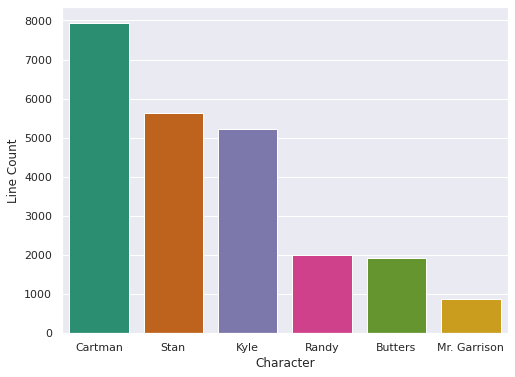

In [5]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.countplot(x='Character', data=sel_df, palette='Dark2', 
                   order=sel_df['Character'].value_counts().index)
ax.set(ylabel='Line Count')
plt.show()

Lets add the word count for each line as a new column so we may compare the distribution of line lengths per character...

In [0]:
sel_df['Word Count'] = sel_df['Processed Line'].map(
    lambda x: str(x).count(' ')+1
    )

In [7]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line,Word Count
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away,8
1,10,1,Kyle,Going away? For how long?,going away for how long,5
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...,15
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...,19
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...,12


Now to display the distribution...

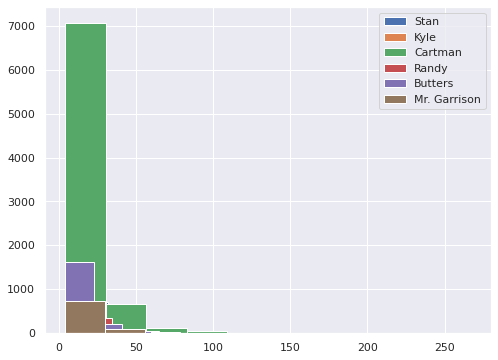

In [8]:
for char in sel_df['Character'].unique():
  plt.hist(list(sel_df.loc[sel_df['Character']==char, 'Word Count']), label=char)
plt.legend(loc='upper right')
plt.show()

We can see almost all the line lengths are less than 50 words long, let's take a closer look by limiting the x-axis to 50, and having bin sizes of 1.

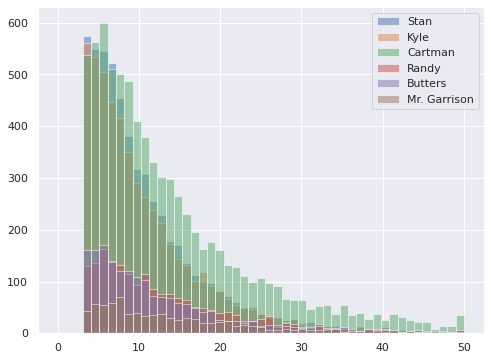

In [9]:
bins = np.linspace(0,50,50)

for char in sel_df['Character'].unique():
  plt.hist(list(sel_df.loc[sel_df['Character']==char, 'Word Count']), 
           bins, alpha=0.5, label=char)
plt.legend(loc='upper right')
plt.show()

For the most part, the line lengths for each character have similar distributions...

Let's take a look at the most frequent unigrams, bigrams and trigrams. For this we will use Sklearn's `CountVectorizer`. We first download the stopwords lexicon to prevent the top unigrams being dominated by boring words...

In [10]:
# Download stop words from NLTK

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def get_ngrams(lines, ngram, top=None):
  # Returns the top 'top' 'ngram'-grams from lines
  c_vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(lines)
  bow = c_vec.transform(lines)
  sums = bow.sum(axis=0)
  freqs = [(word, sums[0, idx]) for word, idx in c_vec.vocabulary_.items() if not word in stopwords]
  freqs = sorted(freqs, key = lambda x: x[1], reverse=True)[:top]  
  grams, counts = map(list, zip(*freqs))

  return grams, counts

In [0]:
unigrams, uni_counts = get_ngrams(all_df['Processed Line'], 1, 15)

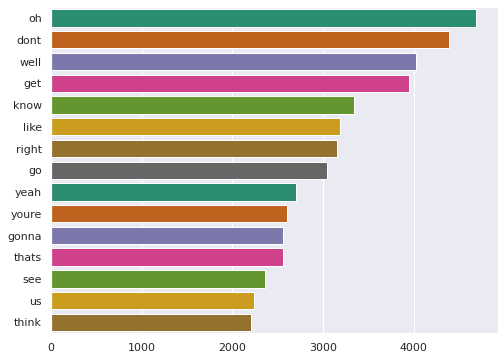

In [13]:
ax = sns.barplot(x=uni_counts, y=unigrams, palette='Dark2')

Turns out it was populated by boring words regardless, let us see the top unigrams of just our chosen characters to see if there is something more interesting there...

In [0]:
char_unigrams, char_uni_counts = get_ngrams(sel_df['Processed Line'], 1, 15)

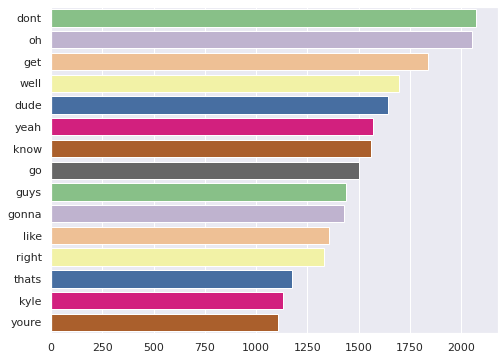

In [15]:
ax = sns.barplot(x=char_uni_counts, y=char_unigrams, palette='Accent')

That's a bit better! The word 'dude' is used nearly 1750 times by our chosen 6 characters, cool! 'Kyle' also features in the top, appearing over 1000 times, likely in an insult from Cartman.

Let us continue with the bigrams...

In [0]:
bigrams, bi_counts = get_ngrams(all_df['Processed Line'], 2, 15)

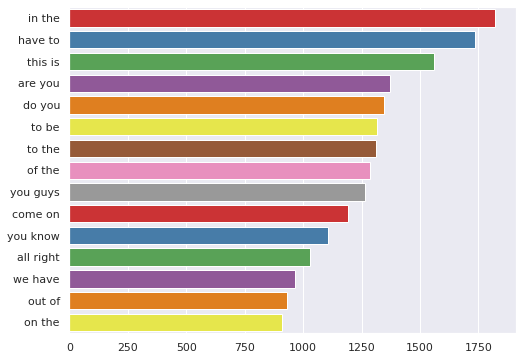

In [22]:
ax = sns.barplot(x=bi_counts, y=bigrams, palette='Set1')

"You guys, you guys!!!" No suprise that 'you guys' appears in the top bigrams for the show.

In [0]:
trigrams, tri_counts = get_ngrams(all_df['Processed Line'], 3, 15)

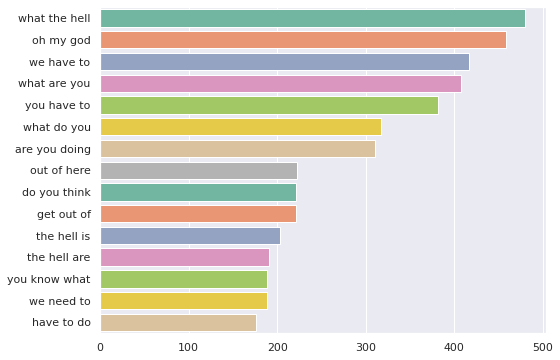

In [19]:
ax = sns.barplot(x=tri_counts, y=trigrams, palette='Set2')

Now this is cool, 'what the hell' appears nearly 500 times across the 18 seasons. I wonder how many times per episode that translates to...

In [23]:
eps = 0

for season in sel_df['Season'].unique():
    eps += sel_df.loc[sel_df['Season']==season, 'Episode'].unique()[-1]

print('There are {} episodes across the 18 seasons!'.format(eps))

There are 257 episodes across the 18 seasons!


Nice, 'what the hell' is said nearly twice per episode! No suprise there either!

Before we dive into the specific ngrams for each of our characters, let us take a look at their word clouds...

In [0]:
def gen_word_cloud(character, df, word_list = []):
  for line in df.loc[df['Character']==character, 'Processed Line']:
    tokens = line.split(' ')
    word_list.extend([word for word in tokens])
  
  print('-----------------\n{}\n-----------------'.format(character))

  wordcloud = WordCloud(width=500, height=250,
                        stopwords=stopwords).generate(' '.join(word_list))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

-----------------
Stan
-----------------


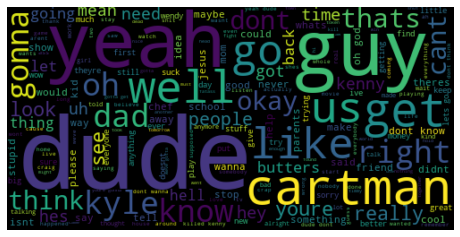

-----------------
Kyle
-----------------


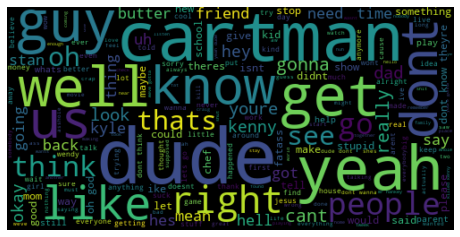

-----------------
Cartman
-----------------


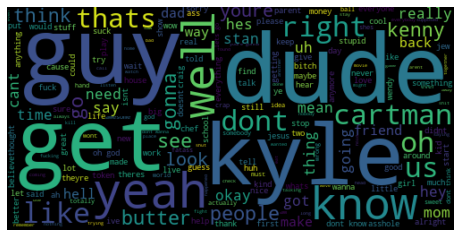

-----------------
Randy
-----------------


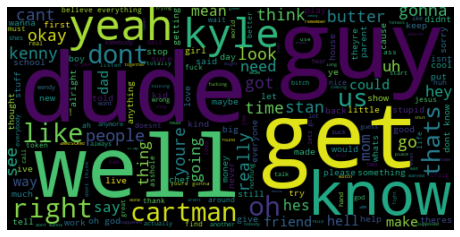

-----------------
Butters
-----------------


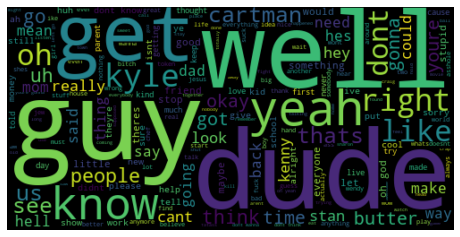

-----------------
Mr. Garrison
-----------------


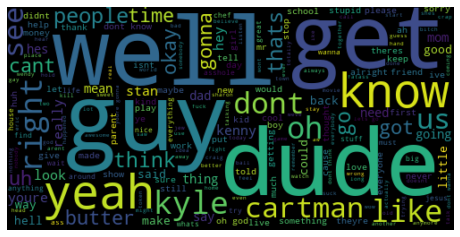

In [25]:
for char in sel_df['Character'].unique():
  gen_word_cloud(char, sel_df)

Whilst word clouds don't tell us too much, they are cool to see. We can see our characters do love the word 'dude'!

We proceed by looking at the most common ngrams for each character...

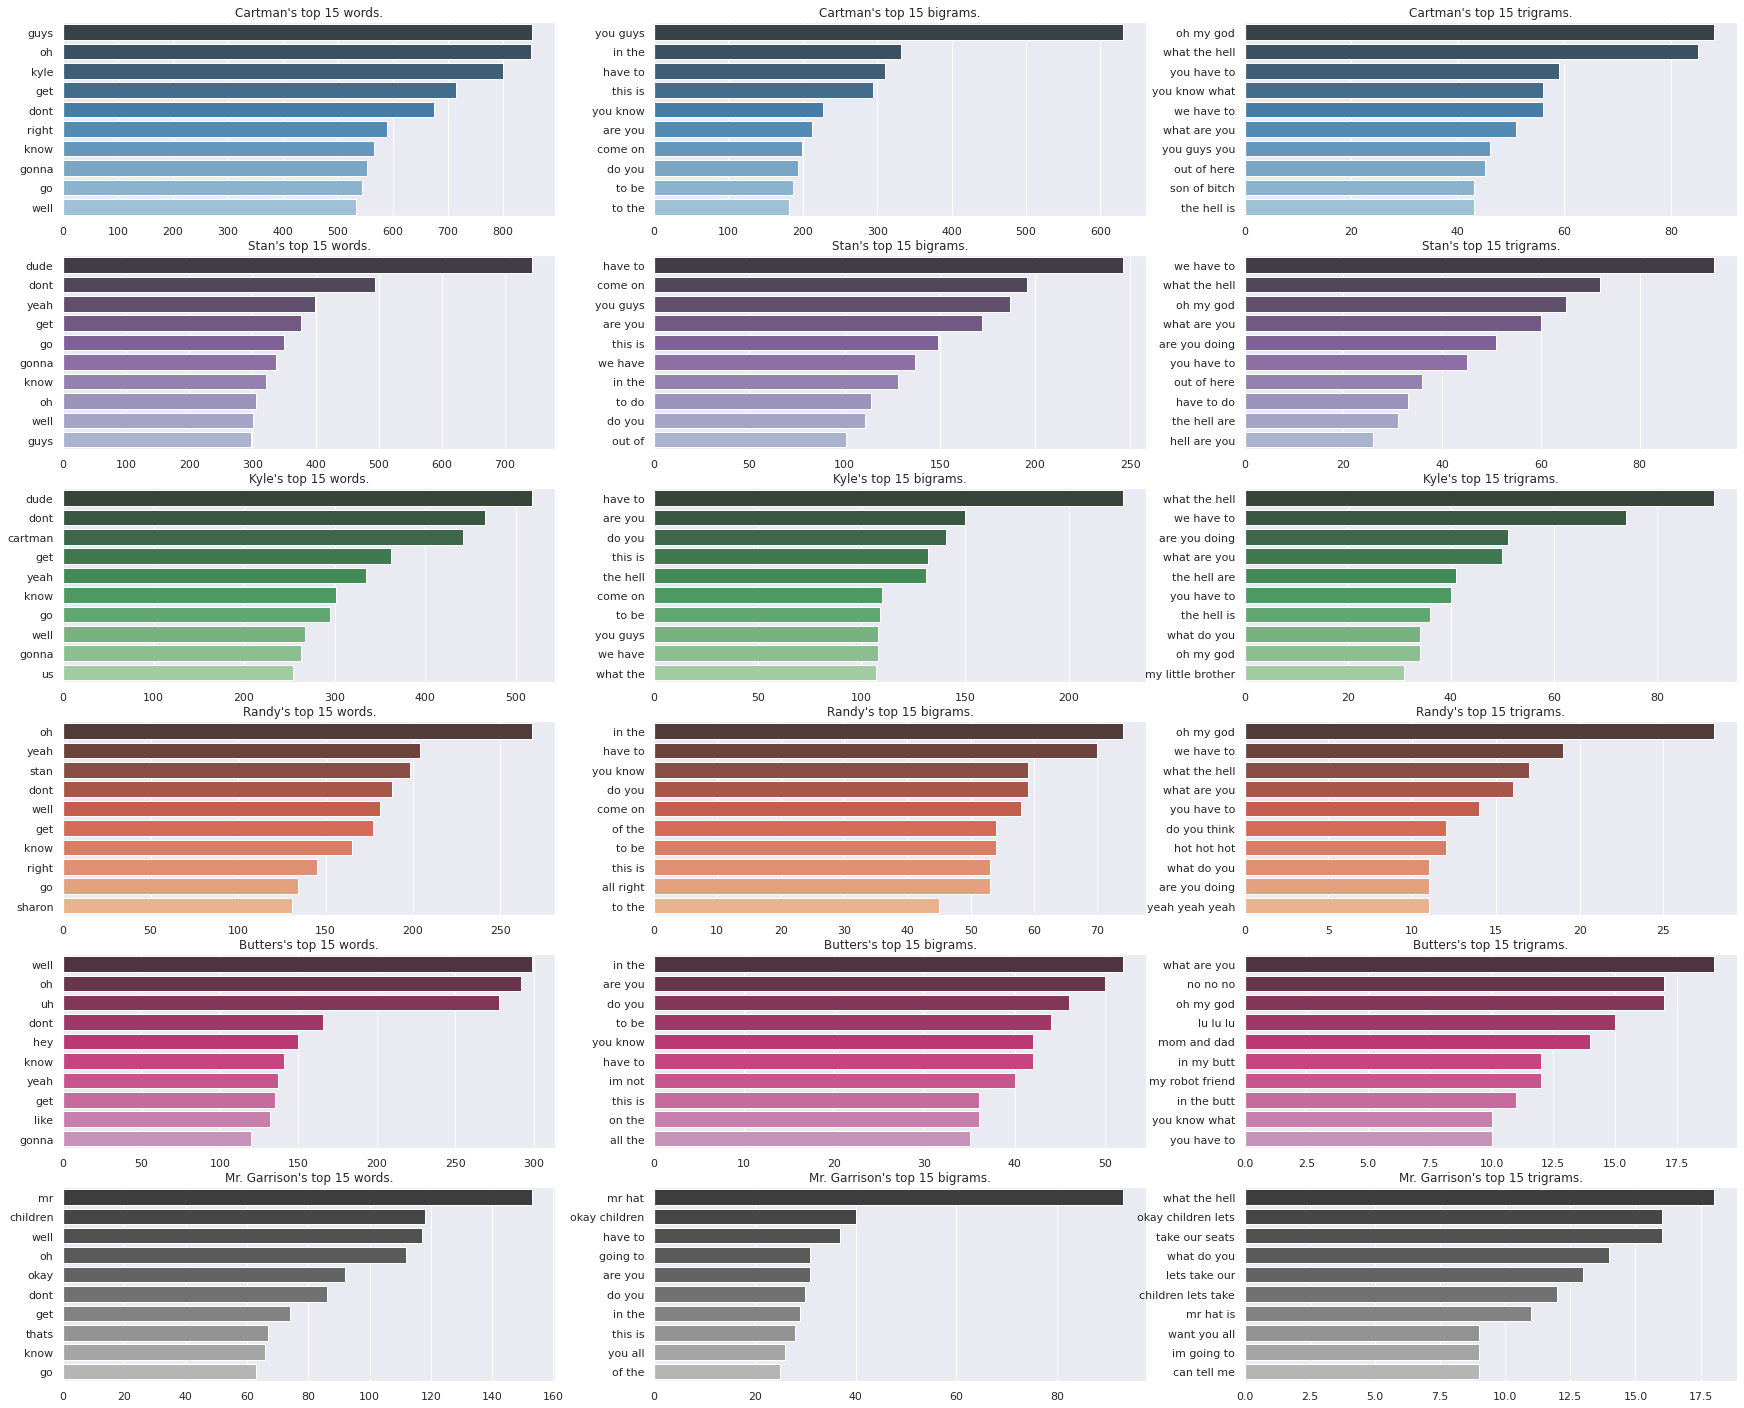

In [26]:
cmap = ['Blues_d', 'BuPu_d', 'Greens_d', 'OrRd_d', 'PuRd_d', 'Greys_d']
titles = ['words', 'bigrams', 'trigrams']
sns.set(rc={'figure.figsize':(30,25)})

f, ax = plt.subplots(6,3)

for j in range(3):
  for i, char in enumerate(sel_df['Character'].value_counts().index):
    ngrams, ngram_counts = get_ngrams(sel_df.loc[sel_df['Character']==char,'Processed Line'], j+1, 10)
    sns.barplot(x=ngram_counts, y=ngrams, palette=cmap[i], ax=ax[i,j]).set_title(
        '{}\'s top 15 {}.'.format(char, titles[j])
        )

There is a lot to unpack here, but this is very cool, and a lot of the ngrams are expected:

'Dude' is the most used word for both Stan and Kyle, whilst Cartman's is 'guys' ! 

Mr. Garrison's top word is no shock, it is 'Mr'... 'Mr. Hat/Twig/Slave'! We see his top bigram is indeed 'Mr. Hat'!

Butters' second most frequent trigram is funny, 'no no no', this makes sense given the character's poor luck and frequent targetting of ridicule.

Randy has 'hot hot hot' appearing in his top trigrams, I am pretty sure this is from a single episode as well! 

Let us now take a look at the sentiment for each character, I'm inclinded to believe Cartman or Randy will be the most negative...

We will use the [VADER](https://github.com/cjhutto/vaderSentiment) module from NLTK (Really powerful sentiment model, capable of capturing nuanced semantics).

In [27]:
# Download vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
senti_model = SentimentIntensityAnalyzer()

In [0]:
def get_sentiment(line):
  ss = senti_model.polarity_scores(line)
  if ss['compound'] >= 0.05:
    return 'positive'
  elif ss['compound'] <= -0.05:
    return 'negative'
  else:
    return 'neutral'

In [0]:
sel_df['Sentiment'] = sel_df['Line'].map(lambda x: get_sentiment(x))

In [31]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line,Word Count,Sentiment
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away,8,neutral
1,10,1,Kyle,Going away? For how long?,going away for how long,5,neutral
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...,15,positive
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...,19,negative
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...,12,neutral


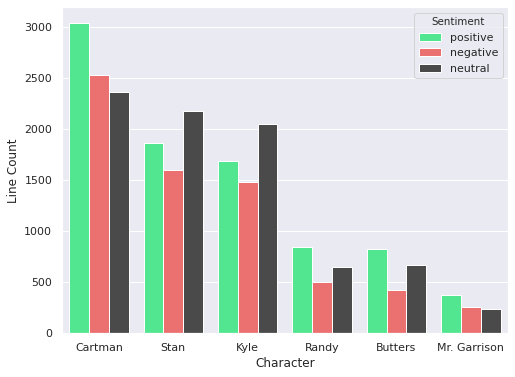

In [34]:
g_r_gr = ['#38ff8b', '#ff5c5c', '#4a4a4a']
sns.set(rc={'figure.figsize':(8,6)})

ax = sns.countplot(x='Character', hue='Sentiment', 
                   hue_order=['positive', 'negative', 'neutral'],
                   order=sel_df['Character'].value_counts().index,
                   data=sel_df, palette=g_r_gr)
ax.set(ylabel='Line Count')
plt.show()

Nice, looks like Cartman isn't that negative afterall! Let's see how the sentiment varies with each season.

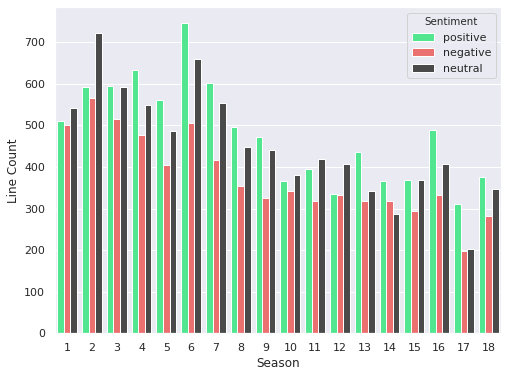

In [35]:
ax = sns.countplot(x='Season', hue='Sentiment', data=sel_df,
                   hue_order=['positive', 'negative', 'neutral'],
                   palette=g_r_gr)
ax.set(ylabel='Line Count')
plt.show()